# Validation

This is the final notebook, primarily dedicated to evaluating the model's performance with incident data that has not been used previously. It employs the best calibration settings, which include a weighted distribution, a minimum direct range of 4 km, and a minimum range of 10 km. The objective is to obtain numerical performance metrics for the model with varying numbers of road inspectors (100, 110, and 120). The optimization model is used to generate these results, similar to the calibration phase. This process aims to provide a final assessment of the model's performance under different inspector scenarios, ultimately gauging its effectiveness. Detailed comments have been omitted since the methodology closely resembles the optimization model and calibration. For a more in-depth understanding of the model and its workings, please refer to the "Combine_results_optimisation" notebook.

Results can be found at the bottom of this Notebook.



In [1]:
pip install pygeos

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install fuzzywuzzy


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import functions
import folium
import pandas as pd 
import geopandas as gpd 
import numpy as np
import networkx as nx
import ast
from fuzzywuzzy import fuzz
from datetime import datetime
import matplotlib.pyplot as plt 
import math
import shapely.wkt
import time
from gurobipy import *
from functions import DutchRDtoWGS84
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")
%matplotlib inline

C:\Users\Klaas Sicking\Documents\studie\studie\Aerospace\advanced data science\Pro\venv\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Load the data

In [4]:
unique_candidates = pd.read_csv('input/unique_candidates.csv')
df = pd.read_csv('input/weight.csv')
# Read the road network shapefile into a GeoDataFrame
gdf = gpd.read_file('input/Snelheid_Wegvakken.shp')
road_network = gdf
G = nx.read_graphml("input/highway_nodes_DiGraph_nb.xml")
all_incidents = pd.read_csv("input/Incidents_clean.csv")
all_incidents['starttime_new'] = pd.to_datetime(all_incidents['starttime_new'])

df_without_weight = pd.read_csv('input/result.csv')
sums_without_weight = df_without_weight.drop(['Date'], axis=1).sum()
df_with_weight = pd.read_csv('input/weight.csv')
sums_with_weight = df_with_weight.drop(['Date', 'Event_Count'], axis=1).sum()

In [5]:
inspectors_amount = [100]

In [4]:
file_path = "result/"

### Test the file_path

In [7]:
# Your string to be saved
my_string = "This is the string I want to save to a text file."

with open(file_path + "test_file.txt", 'w') as file:
    file.write(my_string)

print(f"String saved to {file_path}")
print('Check if the text file is in the right folder!!!')

String saved to result/
Check if the text file is in the right folder!!!


In [8]:
# days for validation
validation_days = ['2019-12-20', '2019-08-02', '2019-12-19', '2019-10-03',
       '2019-12-18', '2019-11-28', '2019-09-16', '2019-12-17',
       '2019-09-27', '2019-12-27', '2019-09-24', '2019-11-26',
       '2019-10-25', '2019-08-01', '2019-08-06', '2019-10-29',
       '2019-10-07', '2019-09-02', '2019-11-25', '2019-10-16',
       '2019-09-17', '2019-09-09', '2019-10-28', '2019-09-06',
       '2019-12-25', '2019-11-12']


input_days = validation_days

### Model Functions
These functions are designed for performing validation and return the numerical results.


In [9]:
def filter_incidents(select_day, inc_df):
    """
    Filter and preprocess incidents for a selected day from the total incidents DataFrame.

    Args:
        select_day (datetime.date): The date for which incidents will be filtered.
        inc_df (pd.DataFrame): The total incidents DataFrame containing incident data.

    Returns:
        pd.DataFrame: A filtered and preprocessed DataFrame with incidents that occurred on the selected day. The DataFrame is prepared for future calculations with additional columns.
    """
    
    # filter to incidents which happened on selected_day
    filt_inc = inc_df[inc_df['starttime_new'].dt.date == select_day]
    filt_inc = filt_inc.copy()

    # add dutch rd coordinates
    DutchRD = filt_inc.apply(lambda x: functions.WGS84toDutchRD(x.primaire_locatie_lengtegraad, 
                                                                x.primaire_locatie_breedtegraad), axis=1)
    filt_inc['dutch_rd_x'] = DutchRD.apply(lambda x: x[0])
    filt_inc['dutch_rd_y'] = DutchRD.apply(lambda x: x[1])

    # add columns to the DF which will be used later
    filt_inc['Node'] = None
    filt_inc['Node_distance_to_incident'] = None
    filt_inc['Node_distance_line'] = None
    filt_inc['Node_line'] = None
    filt_inc['Node_RPE'] = None

    return filt_inc

In [10]:
def find_closest_node(graph, target_node):
    """
    Find the closest matching node in a given graph for a target node name.

    This function calculates the similarity between the target node name and each node in the graph
    and returns the node with the highest similarity score.

    Args:
        graph (networkx.Graph): The graph containing nodes to search for a match.
        target_node (str): The target node name for which to find the closest match.

    Returns:
        str: The node name from the graph that best matches the target node name.
    """
    closest_node = None
    max_similarity = -1

    for node in graph.nodes:
        similarity = fuzz.token_sort_ratio(target_node, node)
        if similarity > max_similarity:
            closest_node = node
            max_similarity = similarity

    return closest_node


In [11]:
def find_nearest_node_incidents_new(x, y, gdf, tolerance=25):
    """
    Find the nearest linestring in a GeoDataFrame to a given point (x, y) and calculate distances.

    This function takes a point with coordinates (x, y) and a GeoDataFrame (gdf) containing linestrings. It determines which linestring from the network is located closest to the specified point and calculates the distance to that linestring. It also checks if the point is within a specified tolerance distance to the nearest linestring.

    Args:
        x (float): The x-coordinate of the point.
        y (float): The y-coordinate of the point.
        gdf (geopandas.GeoDataFrame): The GeoDataFrame containing linestrings.
        tolerance (float, optional): The tolerance distance within which the point is considered to be on the nearest linestring. Defaults to 25.

    Returns:
        dict: A dictionary containing information about the nearest linestring and distances, including:
            - 'Node': The nearest node coordinates.
            - 'Line': The nearest linestring.
            - 'RPE': The road-side information of the nearest linestring.
            - 'Total Distance to Line': The total distance to the nearest linestring.
            - 'Distance to Incident': The Euclidean distance from the point to the nearest node on the linestring.
            If the point is not within the tolerance distance, the dictionary values are set to None.
    """
    point = f"POINT ({x} {y})"
    
    # create a gdf of the point and all lines in the network
    gdf_line = gpd.GeoDataFrame(gdf['geometry'])
    
    # crs is determined by the crs of the linestrings in the network
    gdf_point = gpd.GeoDataFrame(geometry=[shapely.wkt.loads(point)], crs=gdf_line.crs)
    
    # finds the nearest linestring and merges the two gdf's together
    df_n = gpd.sjoin_nearest(gdf_point, gdf_line).merge(gdf_line, left_on="index_right", right_index=True)
    
    # calculates the distance from the point to the linestring
    df_n['distance'] = df_n.apply(lambda r: r["geometry_x"].distance(r["geometry_y"]), axis=1)
    
    # if two or more linestrings are at an equal distance from the point it only considers the first linestring
    if len(df_n) > 1:
        df_n = pd.DataFrame(df_n.iloc[0]).T
        df_n = gpd.GeoDataFrame(df_n, geometry='geometry_y', crs=gdf_line.crs)
    
    # checks whether the point is located within the tolarance distance
    if df_n['distance'].min() < tolerance:
        
        # I copied this from Klaas, I'm not sure why he takes the last coordinate
        nearest_node = df_n['geometry_y'].item().coords[-1]
        nearest_line = df_n['geometry_y'].item()
        nearest_RPE = gdf.iloc[df_n['index_right']]['RPE_CODE'].item()
        total_distance_to_nearest_line = gdf.iloc[df_n['index_right']]['ENDAFSTAND'].item()
        distance_to_incident = np.sqrt((nearest_node[0] - x) ** 2 + (nearest_node[1] - y) ** 2)

        return {'Node': nearest_node,
                'Line': nearest_line,
                'RPE': nearest_RPE,
                'Total Distance to Line': total_distance_to_nearest_line,
                'Distance to Incident': distance_to_incident}
    
    # if the point is not within the tolarance distance it returns an empyt dict
    else:
        return {'Node': None,
                'Line': None,
                'RPE': None,
                'Total Distance to Line': None,
                'Distance to Incident': None}

In [12]:
def calculate_values(row):
    """
    Calculate and store values related to the nearest node and linestring for an incident.

    Args:
        row (pd.Series): A row from the incidents DataFrame containing incident data.
        gdf (geopandas.GeoDataFrame): The GeoDataFrame containing linestrings for the network.

    Returns:
        pd.Series: The input row with additional columns storing calculated values, including:
            - 'Node': The nearest node coordinates.
            - 'Node_distance_line': The total distance to the nearest linestring.
            - 'Node_line': The nearest linestring.
            - 'Node_distance_to_incident': The Euclidean distance from the incident to the nearest node.
            - 'Node_RPE': The road-side information of the nearest linestring.
    """

    x = row['dutch_rd_x']
    y = row['dutch_rd_y']
    result = find_nearest_node_incidents_new(x, y, gdf)
    
    row["Node"] = result['Node']
    row["Node_distance_line"] = result['Total Distance to Line']
    row["Node_line"] = result['Line']
    row['Node_distance_to_incident'] = result['Distance to Incident']
    row['Node_RPE'] = result['RPE']
    
    return row

In [13]:
def drop_inc_out_of_range(inc_df, print_bool=False):
    """
    Drop incidents that are more than 25 meters from the nearest network link.

    Args:
        inc_df (pd.DataFrame): The incidents DataFrame.
        print_bool (bool, optional): If True, the function prints the percentage of dropped rows. Defaults to False.

    Returns:
        pd.DataFrame: A DataFrame containing incidents that are within 25 meters of the nearest road network link.
    """
    
    nan_count = inc_df['Node'].isna().sum()
    if print_bool:
        print(f'Percentage of dropped rows: {(nan_count / len(inc_df) * 100):.2f}%, '+
               'because these incidents are more than 25 meters from the closest road.')

    # all incidents which are too far away from the network are dropped
    incidents = inc_df.dropna().reset_index(drop=True)
    
    return incidents

In [14]:
def create_empty_cost_M(uni_cand, inc_df, G):
    """
    Create an empty cost matrix for candidate and incident nodes.

    Args:
        uni_cand (pd.DataFrame): A DataFrame containing candidate node information, including 'Main_updated' and 'Clone_updated'.
        inc_df (pd.DataFrame): The incidents DataFrame.
        G (networkx.Graph): The graph containing road network information.

    Returns:
        pd.DataFrame: An empty cost matrix with candidate nodes as rows and incident nodes as columns.
        list: The column names (incident nodes) extracted from the incidents DataFrame and present in the graph 'G'.
    """

    num_rows = len(uni_cand)
    placeholder_value = None  # You can use np.nan or any other value as a placeholder
    col_names = [str(node) for node in list(inc_df['Node']) if str(node) in G.nodes()]
    main_names = uni_cand['Main_updated'].values
    clone_names = uni_cand['Clone_updated'].values
    num_columns = len(col_names)
    data = [[placeholder_value] * num_columns for _ in range(num_rows)]
    cost_M = pd.DataFrame(data, columns=col_names)
    cost_M.insert(0, 'Main', main_names)
    cost_M.insert(1, 'Clone', clone_names)
    
    return cost_M, col_names

In [15]:
def parse_coordinate(coordinate_string):
    """
    Parse a string of coordinate values to obtain usable x and y coordinates.

    Args:
        coordinate_string (str): A string containing the coordinate values in the format "(x, y)".

    Returns:
        tuple: A tuple containing the parsed x and y coordinates as floats.
    """
    # Remove parentheses and split the string by comma
    if coordinate_string[-2] == '.':
        coordinate_string = coordinate_string[:-2]
    cleaned_string = coordinate_string.strip('()')
    x_str, y_str = cleaned_string.split(',')

    # Convert the string values to floats
    x = float(x_str.strip())
    y = float(y_str.strip())

    return x, y

In [16]:
def calculate_cost_matrix(cost_M, G, print_bool=False):
    """
    Fill in all values of the cost matrix based on network distances.

    This function populates the cost matrix with values representing distances or costs between candidate nodes and incident nodes. It uses network-based distances where possible, including Euclidean distance and shortest path lengths, while considering constraints for large distances.

    Args:
        cost_M (pd.DataFrame): An empty cost matrix with candidate nodes as rows and incident nodes as columns.
        G (networkx.Graph): The graph containing road network information.
        print_bool (bool, optional): If True, the function prints the time taken for the calculations. Defaults to False.

    Returns:
        pd.DataFrame: The filled cost matrix with calculated distances or costs between candidate and incident nodes.
    """
    
    t0 = time.time()
    cost_M = cost_M.copy()
    no_counter = 0
    
    for row_idx in range(cost_M.shape[0]):

        main_node = cost_M.iloc[row_idx, 0]
        clone_node = cost_M.iloc[row_idx, 1]

        main_node_x, main_node_y = parse_coordinate(main_node)
        
        for col_idx in np.arange(2, cost_M.shape[1]):

            # store coordinates of incident node as tuple
            goal_node = parse_coordinate(cost_M.columns[col_idx])

            # calculate euclidean distance
            dx = main_node_x - goal_node[0]
            dy = main_node_y - goal_node[1]
            distance = np.sqrt(dx*dx + dy*dy)

            # if euclidean distance is larger than 50 km set a large value as cost
            if distance > 50000:
                cost = 1e9

            # otherwise try to calculate shortest path
            else:
                try:
                    cost_main = nx.shortest_path_length(G, str(main_node), str(goal_node), 
                                                   weight='weight')
                    try:
                        cost_clone = nx.shortest_path_length(G, str(clone_node), str(goal_node), 
                                                       weight='weight')
                    except:
                        cost = cost_main
                    else:
                        # add 2 km to the cost of the clone node and then take min cost
                        cost = np.min([cost_main, cost_clone + 2000])

                # if shortest path still throws an error then store other large value
                except:
                    no_counter += 1
                    cost = 2e9

            # store calculated cost in the correct postion in matrix
            cost_M.iloc[row_idx, col_idx] = cost
            
    t1 = time.time()

    total = t1-t0
    if print_bool:
        print(f'calculating the whole cost matrix took: {total/60:.2f} minutes')
        
    return cost_M

In [17]:
def drop_unconnected_incidents(cost_M, print_bool=False):
    """
    Remove incidents with excessively large costs from the cost matrix.

    This function removes incidents from the cost matrix if the cost to the nearest candidate node is larger than 1,000 kilometers. 

    Args:
        cost_M (pd.DataFrame): The cost matrix with candidate nodes as rows and incident nodes as columns.
        print_bool (bool, optional): If True, the function prints the percentage of dropped incidents. Defaults to False.

    Returns:
        pd.DataFrame: The cost matrix with unconnected incidents removed.
    """
    cost_M = cost_M.copy()
    
    # get the minimum cost values for each incident node
    min_values = cost_M.iloc[:, 2:].min()
    columns_to_drop = []

    # iterate over al min costs and if this is larger than 1000 km add it to the drop list
    for col, val in min_values.items():
        if pd.notna(val) and val > 1e6:
            columns_to_drop.append(col)

    cost_M.drop(columns=columns_to_drop, inplace=True)
    if print_bool:
        print(f'{(len(columns_to_drop) / len(min_values) * 100):.2f}% of the incidents are '+
              'dropped because there is no route possible from any candidate node')
    
    return cost_M

In [18]:
def subtract_dist_to_node(cost_M, inc):
    """
    Adjust the cost matrix by subtracting the distance from incidents to their nearest road nodes.

    Args:
        cost_M (pd.DataFrame): A cost matrix with distances or costs between candidate nodes and incidents.
        inc (pd.DataFrame): A DataFrame containing information about incidents, including incident locations and distances to the nearest road nodes.

    Returns:
        pd.DataFrame: An adjusted cost matrix with reduced costs after subtracting distances to nearest road nodes.
        list: A list of incident locations (Dutch RD coordinates).
    """
    incidents_loc = []
    distance_store = []
    result_df = cost_M.copy()  # Create a copy of the DataFrame

    # iterate over all incident nodes
    for name in cost_M.iloc[:, 2:].columns:
        if name[-2] == '.':
            count = int(name[-1])
            N = name[:-2]
        else:
            count = 0
            N = name

        # get the data for the incident node
        match = inc[inc["Node"].astype(str) == N]

        # get the distance from the incident to the end node
        dist = match['Node_distance_to_incident'].values
        distance_to_node = dist[count]

        # get the dutch rd coordinates of the incident
        incident_loc = (match["dutch_rd_x"].values[0], match["dutch_rd_y"].values[0])

        incidents_loc.append(incident_loc)
        distance_store.append(distance_to_node)

    result_df.iloc[:, 2:] -= distance_store
    result_df.iloc[:, 2:] = result_df.iloc[:, 2:].abs()
    
    return result_df, incidents_loc

In [19]:
def store_cost_matrix_in_arrays(cost_M):
    """
    Store the values in the cost matrix in arrays for candidates and incidents.

    Args:
        cost_M (pd.DataFrame): The cost matrix with candidate nodes as rows and incident nodes as columns.

    Returns:
        np.ndarray: The cost matrix values for distances or costs between candidates and incidents.
        np.ndarray: The coordinates of candidate nodes.
        np.ndarray: The coordinates of incident nodes.
    """
    # store the values in arrays
    cost_matrix = np.array(cost_M.iloc[:, 2:].values)
    final_incidents_nodes = np.array(cost_M.columns[2:])
    final_candidates = np.array(cost_M['Main'].values)

    # store the converted coordinate values into a new array
    candidates = np.array([parse_coordinate(node) for node in final_candidates])
    incidents = np.array([parse_coordinate(node) for node in final_incidents_nodes])
    
    return cost_matrix, candidates, incidents

In [20]:
def run_gurobi_model(selected_day, cost_M, cand_arr, inc_arr, print_bool=False):
    """
    Create a Gurobi optimization model for assigning inspectors to incidents.

    This function sets up a Gurobi optimization model, adds the objective function and constraints, and then runs the optimization to determine the assignment of inspectors to incidents. It returns the results, including the selected inspector nodes and a binary matrix indicating the assignment of inspectors to incidents.

    Args:
        selected_day (datetime.date): The date for which the optimization is performed.
        cost_M (np.ndarray): A cost matrix with distances or costs between candidate nodes and incidents.
        cand_arr (np.ndarray): Coordinates of candidate nodes.
        inc_arr (np.ndarray): Coordinates of incident nodes.
        print_bool (bool, optional): If True, the function prints summary results. Defaults to False.

    Returns:
        list: A list of results including the selected day, number of inspectors, number of incidents,
              objective function value, average response time (in seconds), and average response time (in minutes).
        list: A list of selected inspector nodes.
        np.ndarray: A binary matrix indicating the assignment of inspectors to incidents.
    """
    # initialise model
    model = Model("Road inspectors")
    
    # Setting up the indices
    N = np.arange(cand_arr.shape[0])
    K = np.arange(inc_arr.shape[0])

    # Parameters
    inspector_cap = 10 # the maximum amount of incidents an inspector can handle in a day
    N_inspectors = 120 # the maximum amount of inspectors
    speed = 100 # a constant speed value in km/h

    if inspector_cap * N_inspectors < inc_arr.shape[0]:
        raise ValueError("Not enough inspectors!")
        
    pair = [(i, k) for i in N for k in K]

    # Setting up the variables
    x = model.addVars(pair, vtype=GRB.BINARY, name="x")
    c = model.addVars(N, vtype=GRB.BINARY, name="c")

    model.Params.MIPGap = 0.01 # set the threshold value at which the optimisation stops to 1.0%
    model.Params.IntegralityFocus=0
    model.update()
    
    # Objective function: Minimise the total travel cost
    model.setObjective(quicksum(cost_M[i, k] * x[i, k] for i in N for k in K),
                       GRB.MINIMIZE)
    
    # Constraints: All incidents must be handled
    model.addConstrs(quicksum(x[i, k] for i in N) == 1 for k in K)
    
    # Constraints: Inspector capacity
    model.addConstrs(quicksum(x[i, k] for k in K) <= (inspector_cap * c[i]) for i in N)
    
    # Constraints: Number of inspectors
    model.addConstr(quicksum(c[i] for i in N) <= N_inspectors)
    
    # Run the model
    model.update()
    model.optimize()
    
    # Collect the results
    inspectors = []



    # Collect the matching
    match_arr = np.zeros((len(N), len(K)))
    for i in N:
        for k in K:
            match_arr[i, k] = x[i, k].x

    for i in N:
        if c[i].x == 1:
            inspectors.append(i)
    
    # Calculate the average response time in seconds
    ave_time = model.ObjVal / len(inc_arr) / 1000 / speed * 3600
    # Collect objective date, number of inspectors, number of incidents,
    # objective function values, average response time[sec], average response time [min]
    output = [selected_day, len(N), len(K),
               model.ObjVal, ave_time, ave_time/60]
            
    # Summary of results
    if print_bool:
        print(f'Minimum total cost is {model.ObjVal/1000:.2f} km')
        print(f'Number of inspectors is {len(inspectors)}')
        print(f'The distance per inspector is {model.ObjVal / len(inspectors) / 1000 :.2f} km')

        
        print(f'Average time to reach the incident is {ave_time//60:.0f} minutes and {ave_time%60:.0f} seconds')
    
    return output, inspectors, match_arr

In [21]:
def process_inspectors_data(inspectors_df, G):
    """
    Process inspector location data and update it with nearest road nodes.

    Args:
        inspectors_df (pd.DataFrame): DataFrame containing inspector location data.
        G (networkx.Graph): Graph representing road networks for finding nearest road nodes.

    Returns:
        pd.DataFrame: Processed inspector location data with updated coordinates.
    """
    # Rename and select relevant columns
    inspectors_df.rename(columns={'Other_side': 'Clone'}, inplace=True)
    inspectors_df = inspectors_df[['X_value', 'Y_value', 'Clone']]

    # Convert all coordinates to string
    inspectors_df['Main'] = inspectors_df.apply(lambda row: str((row['X_value'], row['Y_value'])), axis=1)
    inspectors_df = inspectors_df[['Main', 'Clone']]

    # Add the coordinates from the find_closest_node function
    inspectors_df['Main_updated'] = inspectors_df['Main'].apply(lambda x: find_closest_node(G, x))
    inspectors_df['Clone_updated'] = inspectors_df['Clone'].apply(lambda x: find_closest_node(G, x))
    
    return inspectors_df


In [22]:
def run_everything_for_optimisation (selected_day, all_incidents, inspectors_df, G, input_day):
    """
    Run all calculations for the optimization model.

    This function performs a series of calculations and optimization steps for the road inspector allocation model based on the following input parameters:
    
    Args:
        selected_day (datetime.date): The day for which calculations are performed.
        all_incidents (pd.DataFrame): DataFrame containing information about all incidents.
        inspectors_df (pd.DataFrame): DataFrame with inspector location data.
        G (networkx.Graph): Network graph representing road networks.
        input_day (str): The input day used in file naming or other purposes.

    Returns:
        tuple: A tuple containing the following elements:
            - output (list): Results including the number of inspectors, incidents, objective value, average response time in seconds, and average response time in minutes.
            - match_arr (numpy.ndarray): A 2D array representing the assignment of inspectors to incidents.
            - incidents_location (pd.DataFrame): DataFrame containing incident locations.
            - inspectors (list): List of inspector locations selected by the optimization model.
    """
    # inspectors_df = process_inspectors_data(inspectors_df, G)
    
    filtered_incidents = filter_incidents(selected_day, all_incidents)

    incidents_results = filtered_incidents.apply(calculate_values, axis=1)
    
    incidents = drop_inc_out_of_range(incidents_results)

    cost_matrix, column_names = create_empty_cost_M(inspectors_df, incidents, G)

    fill_cost_matrix = calculate_cost_matrix(cost_matrix, G)

    clean_cost_matrix = drop_unconnected_incidents(fill_cost_matrix)
    
    end_cost_matrix, incidents_loc = subtract_dist_to_node(clean_cost_matrix, incidents)
    
    incidents_location = pd.DataFrame(incidents_loc, columns=['x', 'y'])

    cost_matrix, candidates, incidents = store_cost_matrix_in_arrays(end_cost_matrix)

    if cost_matrix.shape[0] != candidates.shape[0] or cost_matrix.shape[1] != incidents.shape[0]:
        raise ValueError("Dimensions do not match")

    output, inspectors, match_arr = run_gurobi_model(selected_day, cost_matrix, candidates, incidents, print_bool=True)

    return output, match_arr, incidents_location, inspectors
    

In [23]:
def run_calculation_for_all_days(input_days, all_incidents, inspectors_df,  G):
    """
    Perform optimization calculations with optimal locations for multiple days.

    Args:
        input_days (list of str): A list of date strings in the format 'YYYY-MM-DD' for which the calculations will be performed.
        all_incidents (pd.DataFrame): DataFrame containing information about all incidents.
        inspectors_df (pd.DataFrame): DataFrame with inspector information.
        G (networkx.Graph): Network graph representing road networks.

    Returns:
        pd.DataFrame: A DataFrame containing the calibration results of the optimization calculations for each input day. Columns include 'Date', 'Number of inspectors', 'Number of Incidents', 'Objective Value', 'Average response time [s]', and 'Average response time [min]'.
    """
    start_time_calculations = time.time()

    dict_match_arr = {}
    dict_incidents_location = {}
    df_obj = pd.DataFrame(columns=['Date', 'Number of inspectors',
                                   'Number of Incidents', 'Objective Value',
                                   'Average response time [s]', 'Average response time [min]'])


    for i, day in enumerate(input_days):
        try:
            day_start_time = time.time()

            print(f'running day {i+1} out of {len(input_days)}')

            selected_day = datetime.strptime(day, '%Y-%m-%d').date()

            output, match_arr, incidents_location, inspectors = run_everything_for_optimisation(selected_day, all_incidents, inspectors_df, G, day)
            dict_match_arr[day] = match_arr
            dict_incidents_location[day] = incidents_location
            df_obj.loc[i] = output

            day_end_time = time.time()

            print(f'calculating day {i+1} took: {(day_end_time - day_start_time)/60:.2f} minutes')
        except Exception as e:
            print(f'Error for date: {day}\n{str(e)}')
            continue

    end_time_calculations = time.time()
    print(f'The calculations took: {(end_time_calculations - start_time_calculations)/60:.2f} minutes')

    return df_obj


In [24]:
for number in inspectors_amount:
    inspector_locations = pd.read_csv(f'Input/Inspectors__loc_{number}_with_weight_10000_4000.csv')
    inspectors_df = process_inspectors_data(inspector_locations, G)
    df_obj = run_calculation_for_all_days(input_days, all_incidents, inspectors_df, G )
    df_obj.to_csv(file_path + f"Results_{number}.csv")

running day 1 out of 26
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-10
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1076 rows, 97600 columns and 195200 nonzeros
Model fingerprint: 0x88f25015
Variable types: 0 continuous, 97600 integer (97600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [3e+00, 2e+09]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 7.280146e+11
Presolve removed 1 rows and 100 columns
Presolve time: 0.30s
Presolved: 1075 rows, 97500 columns, 195000 nonzeros
Variable types: 0 continuous, 97500 integ

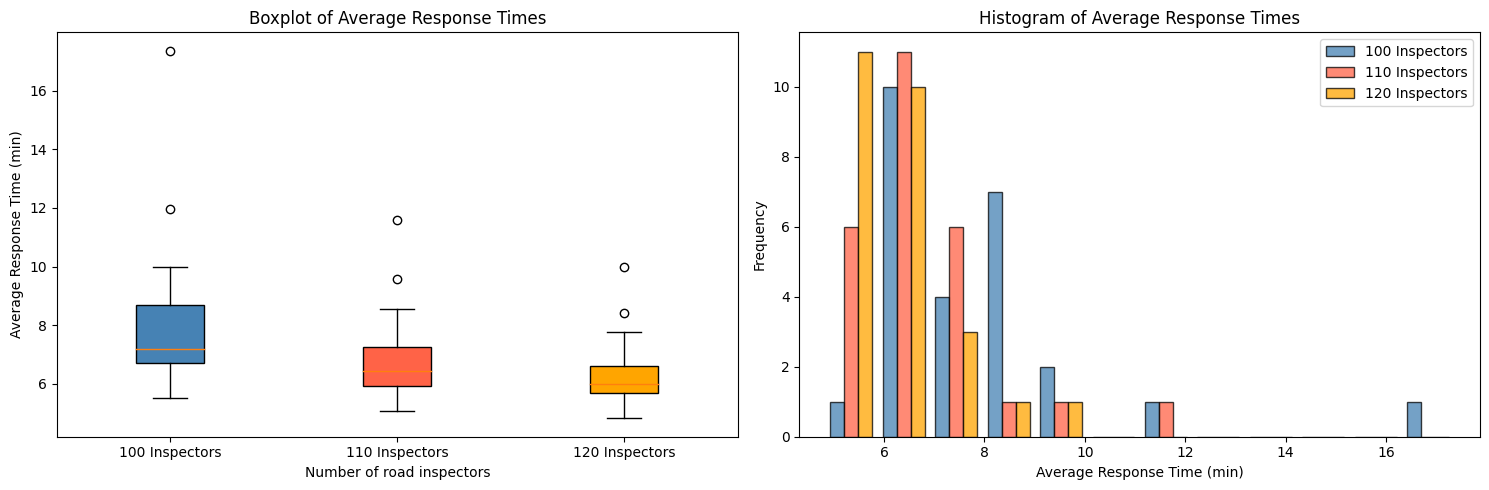

In [23]:
%matplotlib inline

# Assuming you have loaded results for 100, 110, and 120 inspectors into separate DataFrames
result_100 = pd.read_csv(file_path + "Results_100.csv")
result_110 = pd.read_csv(file_path + "Results_110.csv")
result_120 = pd.read_csv(file_path + "Results_120.csv")

# Create subplots with different widths
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the width here

# Custom colors for boxplots
boxplot_colors = ['steelblue', 'tomato', 'orange']

# Boxplots with custom colors
boxplot_data = [result_100['Average response time [min]'], result_110['Average response time [min]'], result_120['Average response time [min]']]
boxplot_labels = ['100 Inspectors', '110 Inspectors', '120 Inspectors']
boxprops = dict(facecolor='white')
flierprops = dict(marker='o', markerfacecolor='red', markersize=6, linestyle='none')
for patch, color in zip(ax1.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True)['boxes'], boxplot_colors):
    patch.set_facecolor(color)
ax1.set_xlabel('Number of road inspectors')
ax1.set_ylabel('Average Response Time (min)')
ax1.set_title('Boxplot of Average Response Times')

# Custom colors for histograms
hist_colors = ['steelblue', 'tomato', 'orange']

# Histograms with custom colors
hist_data = [result_100['Average response time [min]'], result_110['Average response time [min]'], result_120['Average response time [min]']]
hist_labels = ['100 Inspectors', '110 Inspectors', '120 Inspectors']
ax2.hist(hist_data, bins=12, edgecolor='k', alpha=0.75, color=hist_colors, label=hist_labels)
ax2.set_xlabel('Average Response Time (min)')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Average Response Times')
ax2.legend()

plt.tight_layout()  # Ensures proper spacing
plt.savefig('Final_results.png')
plt.show()
